The celebA dataset comprises over 200,000 jpeg images of various sizes, containing 10,000 different celebrities. Labels are provided for 40 facial attributes (hair style etc.) as well as bounding box coordinates for the faces. 

The original compilers of the dataset used it to train a model to classify the attributes (Y. Sun, X. Wang, and X. Tang. "Deep learning face representation from predicting 10,000 classes". In CVPR, 2014.). Another interesting use was to use the detected attributes to score bounding box proposals for likelihood of containing a face (S. Yang, P. Luo, C. Change Loy and X. Tang. "From Facial Parts Responses to Face Detection: A Deep Learning Approach". arXiv:1509.06451).

Popular approaches for segmenting an image like the YOLO and Faster R-CNN models use very deep models and learn to classify the images in parallel with learning to draw boundary boxes. 

Here I explore whether it's possible to perform rough boundary box regression alone on a scaled down version of this dataset with a smaller convNet of four layers.

First the images and labels were scaled down to a maximum dimension of 128 pixels. For the training, any dimension lower than 128 will be zero padded so that all images are 128x128, so the boundary boxes are offset to reflect that.

In [ ]:
import os
from PIL import Image

dirPath = "/Users/graeme/PycharmProjects/celebA/img_celeba/"


# create thumbnails
size = 128, 128

for infile in os.listdir(dirPath):
    # outfile = os.path.splitext(infile)[0] + ".thumbnail"
    # if infile != outfile:
    try:
        im = Image.open(os.path.join(dirPath,infile))
        width, height = im.size
        im.thumbnail(size, Image.ANTIALIAS)
        outpath = os.path.join(dirPath,'thumbs/',infile)
        im.save(outpath, "JPEG")
    except IOError:
        print("cannot create thumbnail for", infile)


# # create new boundary box label dictionaries for scaled down version
def create_dict(file):
    dict = {}
    handle = open(file)
    for line in handle:
        contents = line.split()
        dict[contents[0]] = contents[1:]
    return dict


dictBB = create_dict('/Users/graeme/Downloads/Anno/list_bbox_celeba.txt')
dictBBnew = dictBB
imList = os.listdir(os.path.join(dirPath,'thumbs/'))

n = 0
for i in imList:
    try:
        im = Image.open(os.path.join(dirPath, i))
        width, height = im.size
        im = Image.open(os.path.join(dirPath,'thumbs/',i))
        widthNew, heightNew = im.size
        xScale = widthNew / width
        xOffset = int((128 - widthNew) / 2)
        yOffset = int((128 - heightNew) / 2)
        yScale = heightNew / height
        bbOld = [float(j) for j in dictBB[i]]
        bbNew = [int(a * b) for a, b in zip(bbOld, [xScale,yScale,xScale,yScale])]
        bbNew = [str(a + b) for a, b in zip(bbNew, [xOffset, yOffset, xOffset, yOffset])]
        dictBBnew[i] = bbNew
    except:
        continue
    n += 1
    if n%1000==0:
        print(n)

# save new dictionary
fout = dirPath+"BBdictNew.txt"
fo = open(fout, "w")
m=0
for k, v in dictBBnew.items():
    m+=1
    bb = ' '.join(v)
    fo.write(str(k)+ ' ' +  bb  + '\n')

fo.close()


The model used has 3 convolutional layers, followed by one fully connected layer and then a classier. It can achieve a  classification accuracy upwards of 80% on the CIFAR-10 dataset if trained optimally. The convolutions are 5x5 with 64 features each and the fully connected layer has 32 features. There are 3x3 max-pooling operations (with a stride of 2) preceeding layer 1 and following layers 1 and 3, plus there is a skip connection from the output of layer 1 to layer 4. Batch normalisation is used after every layer, which speeds up learning and reduces hyperparameter selection sensitivity.

First the label files are read and lists created in the same order as the image lists:

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import Model

# model parameters
convWidth = 5
conv1feat = 64
conv2feat = 64
conv3feat = 64
linear1feat = 32
batchSize = 50
numEpochs = 1
etaIn = 0.1
gammaIn = 0.9

# data parameters
dirPath = "/Users/graeme/PycharmProjects/celebA/img_celeba/"
logPath = "/Users/graeme/PycharmProjects/celebA/log"
cropWidth = 128#int(176/4)
cropHeight = 128#int(208/4)
imChanels = 3
numLabels = 44
min_fraction_of_examples_in_queue = 0.01
num_preprocess_threads = 16
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 160000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 19000


def create_dict(file):
    dict = {}
    handle = open(file)
    for line in handle:
        contents = line.split()
        dict[contents[0]] = contents[1:]
    return dict


# create label dictionaries
dictBB = create_dict('/Users/graeme/PycharmProjects/celebA/BBdictNew.txt')
dictAtt = create_dict('/Users/graeme/Downloads/Anno/list_attr_celeba.txt')
for key, values in dictAtt.items():
    try:
        pos = key.find('.jpeg')
        # valueList = values.split(',')
        for element in range(len(values)):
            if values[element] == '-1':
                values[element] = 0
            else:
                values[element] = 1
        dictAtt[key] = values#','.join(valueList)
    except:
        continue
dictEval = create_dict('/Users/graeme/Downloads/list_eval_partition.txt')

# count examples in each set
trainExam = sum(i[0] == '0' for i in dictEval.values())
valExam = sum(i[0] == '1' for i in dictEval.values())
testExam = sum(i[0] == '2' for i in dictEval.values())

# create file and label lists using dictionaries
imList = os.listdir(os.path.join(dirPath,'thumbs/'))
del imList[30088]  # .DS file
trainFiles=[]
trainLabels=[]
evalFiles=[]
evalLabels=[]
testFiles=[]
testLabels=[]
for i in imList:
    bb = [float(j) for j in dictBB[i]]
    partition = dictEval[i]
    if partition[0] == '0':
        trainFiles.append(os.path.join(dirPath,'thumbs/', i))
        trainLabels.append(bb + dictAtt[i])
    elif partition[0] == '1':
        evalFiles.append(os.path.join(dirPath,'thumbs/', i))
        test = dictBB[i]
        evalLabels.append(bb + dictAtt[i])
    elif partition[0] == '2':
        testFiles.append(os.path.join(dirPath,'thumbs/', i))
        testLabels.append(bb + dictAtt[i])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


After preparing the data, the model is loaded from the Model class where it is defined.

In [2]:
## model training
images = tf.placeholder(dtype=tf.float32, shape=[None,cropHeight,cropWidth,imChanels])
labels = tf.placeholder(dtype=tf.int64, shape=[None,numLabels])

# create model
model = Model.Model(images,labels, convWidth, conv1feat, conv2feat, conv3feat, linear1feat)

The classifier will be trained to output a vector giving the starting x & y coordinates and the height and width of the boundary box. The loss fuction used will add a penalty for incorrect end coordinates, so as to discourage the model from prioritising learning the boundary box size over position. 

The loss function used is mean squared error and optimised using Nesterov's accelerated gradient method.

In [3]:
model._detect_bb(cropWidth,cropHeight,batchSize)
model._use_nesterov(eta=etaIn,gamma=gammaIn)

Next, the datasets are loaded using tensorflow functionality to create a preprocessing queue. The images are normalised, which makes learning easier.

In [4]:
restoreMode = False

def _readFile2(fileName, labels):
    # function to decode image, crop and normalise, can be used as a mapping method for a dataset
    imageFile = tf.read_file(fileName)
    image = tf.image.decode_image(imageFile,channels=imChanels)
    if restoreMode is False:
        image = tf.image.per_image_standardization(image)
    image = tf.image.resize_image_with_crop_or_pad(image, cropHeight, cropWidth)
    return image, labels


def getData2(fileNames, fileLabels, batchSize, testFlag):
    # function to create datasets for efficient processing, can be queued up by tf
    if testFlag > 0:
        num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL
    else:
        num_examples_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN
    min_queue_examples = int(num_examples_per_epoch * min_fraction_of_examples_in_queue)

    dataset = tf.data.Dataset.from_tensor_slices((fileNames, fileLabels))
    dataset = dataset.map(_readFile2,num_parallel_calls=num_preprocess_threads)
    dataset = dataset.shuffle(buffer_size=min_queue_examples)
    dataset = dataset.batch(batchSize)
    return dataset


# create datasets
with tf.device('/cpu:0'):
    trainData = getData2(trainFiles, trainLabels, batchSize, testFlag=0)
    valData = getData2(evalFiles, evalLabels, batchSize, testFlag=1)
    testData = getData2(testFiles, testLabels, batchSize=testExam, testFlag=2)

# create iterators
iteratorTrain = tf.data.Iterator.from_structure(trainData.output_types, trainData.output_shapes)
iteratorVal = tf.data.Iterator.from_structure(valData.output_types, valData.output_shapes)
iteratorTest = tf.data.Iterator.from_structure(testData.output_types, testData.output_shapes)
next_batchTrain = iteratorTrain.get_next()
next_batchVal = iteratorVal.get_next()
next_batchTest = iteratorTest.get_next()
training_init_op = iteratorTrain.make_initializer(trainData)
validation_init_op = iteratorVal.make_initializer(valData)
test_init_op = iteratorTest.make_initializer(testData)

# initialise tf
sess = tf.InteractiveSession()

Now we train the model. Iterations are limited to 100 as we shall see the model converges by then.

Step 0, Train Loss 0.237875, Val Loss 0.191324
Step 10, Train Loss 0.102317, Val Loss 0.147486
Step 20, Train Loss 0.0600575, Val Loss 0.116429
Step 30, Train Loss 0.0560918, Val Loss 0.0716314
Step 40, Train Loss 0.0278722, Val Loss 0.0412231
Step 50, Train Loss 0.031112, Val Loss 0.0355213
Step 60, Train Loss 0.037667, Val Loss 0.0409039
Step 70, Train Loss 0.0231391, Val Loss 0.035265
Step 80, Train Loss 0.0361555, Val Loss 0.0314031
Step 90, Train Loss 0.0245483, Val Loss 0.0317307


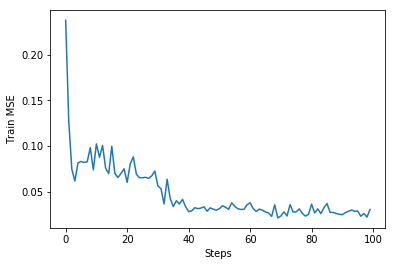

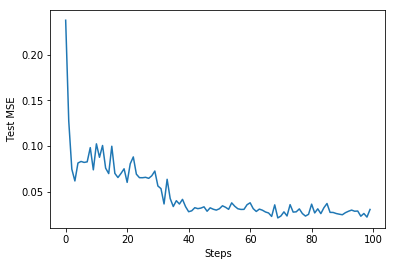

In [6]:
model._add_tensorboard(logPath, sess)
sess.run(tf.global_variables_initializer())

# training iterations
trainLosses = []
valLosses = []
for epochLoop in range(numEpochs):
    sess.run(training_init_op)
    sess.run(validation_init_op)

    for iterLoop in range(100):#range(int(trainExam/batchSize)):
        imagesBatch, labelsBatch = sess.run(next_batchTrain)
        model.trainStep.run(feed_dict={images:imagesBatch,labels:labelsBatch})
        trainLoss, trainSummary = sess.run([model.loss, model.merged],
                                           feed_dict={images: imagesBatch, labels: labelsBatch})
        model.train_writer.add_summary(trainSummary, iterLoop)
        trainLosses.append(trainLoss)

        #test loss
        imagesBatch, labelsBatch = sess.run(next_batchVal)
        valLoss, valSummary = sess.run([model.loss, model.merged],
                                       feed_dict={images: imagesBatch, labels: labelsBatch})
        model.test_writer.add_summary(valSummary, iterLoop)
        valLosses.append(trainLoss)

        if iterLoop %10 ==0:
            print('Step %d, Train Loss %g, Val Loss %g' % (iterLoop,trainLoss,valLoss))

save_path = model.saver.save(sess, logPath+"model.ckpt")
plt.figure(1)
plt.xlabel('Steps')
plt.ylabel('Train MSE')
plt.plot(trainLosses)
plt.figure(2)
plt.xlabel('Steps')
plt.ylabel('Test MSE')
plt.plot(valLosses)
plt.show()

Now to test the model.

In [8]:
restoreMode = True

imagesBatch, labelsBatch = sess.run(next_batchVal)
labelsPred = model.labels.eval(feed_dict={images: imagesBatch, labels: labelsBatch})

error = np.around(labelsBatch[:,:4] - labelsPred*128)
for line in range(10):
    print('True: %s, Predicted: %s, Error: %s' % 
          (labelsBatch[line,:4], np.around(labelsPred[line,:4]*128), error[line,:]))


True: [ 73.  19.  23.  49.], Predicted: [ 54.  14.  27.  59.], Error: [ 19.   5.  -4. -10.]
True: [ 56.  19.  65.  58.], Predicted: [ 49.   8.  56.  33.], Error: [  7.  11.   9.  25.]
True: [ 39.  11.  76.  76.], Predicted: [ 53.  14.  48.  30.], Error: [-14.  -3.  28.  46.]
True: [ 36.  25.  59.  98.], Predicted: [ 50.  16.  43.  67.], Error: [-14.   9.  16.  31.]
True: [ 37.  16.  60.  82.], Predicted: [ 48.   4.  45.  64.], Error: [-11.  12.  15.  18.]
True: [ 48.   9.  41.  28.], Predicted: [ 49.  15.  64.  45.], Error: [ -1.  -6. -23. -17.]
True: [ 43.  25.  83.  99.], Predicted: [ 36.  17.  75.  76.], Error: [  7.   8.   8.  23.]
True: [ 26.  21.  37.  59.], Predicted: [ 41.  34.  47.  55.], Error: [-15. -13. -10.   4.]
True: [  32.   14.   93.  108.], Predicted: [ 35.  24.  68.  76.], Error: [ -3. -10.  25.  32.]
True: [ 31.  18.  69.  78.], Predicted: [ 48.   7.  57.  62.], Error: [-17.  11.  12.  16.]


There's no consistent pattern in accuracy from looking at a sample like this, suggesting the error for most of the coordinates is around the same. The test MSE corresponds to an arror of around +/-22 pixels which covers around a third of the image.

With the model having converged at this level quite quickly, it appears it does not have the depth to complete this task to any greater accuracy. Although typically, models like these would cycle over the entire dataset many times (versus about 3% of it here), so perhaps given more time and with optimisation of hyperparameters slow gains would be made.

The conclusion from this data though is that the a more complex model is likely to be required. 